# Setup

In [1]:
import os
import shap
if not 'notebookDir' in globals():
    notebookDir = os.getcwd()
print('notebookDir: ' + notebookDir)
os.chdir(notebookDir)

notebookDir: C:\Users\arpit\Desktop\TUM\SEM-2\NLP\understanding-opinions-on-social-media\data exploration


# Data preparation

In [2]:
import pandas as pd
pd.options.display.max_columns = 100

In [3]:
dataset_path = '../data/USParties/v2/USParties_combined.csv'
output = '../data/USParties/v2/USParties_preprocessed.csv'

In [4]:
df = pd.read_csv(dataset_path, low_memory=False)
df_len = len(df)
df

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,Post Created Date,Post Created Time,Type,Total Interactions,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Video Share Status,Is Video Owner?,Post Views,Total Views,Total Views For All Crossposts,Video Length,URL,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Sponsor Category,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),Overperforming Score,Party
0,Senator Dan Sullivan,SenDanSullivan,1.499142e+15,GOVERNMENT_OFFICIAL,US,The official Facebook page for Senator Dan Sul...,2015-02-21 00:42:55 CET,13921,27078,2021-04-26 22:51:01 CEST,2021-04-26,22:51:01,Live Video Complete,"118,453",35811,18219,47169,4602,2298,507,400,9265,182,owned,Yes,810971,1507782,0,08:00:00,https://www.facebook.com/1499142123704271/post...,"Today, a leaked interview with Iran’s foreign ...",https://www.facebook.com/SenDanSullivan/videos...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"118,453",779.30,0
1,Senator Ted Cruz,SenatorTedCruz,3.154965e+14,GOVERNMENT_OFFICIAL,US,Official Facebook page of U.S. Sen. Ted Cruz (...,2014-08-18 20:43:36 CEST,1355559,1738544,2021-04-29 04:14:34 CEST,2021-04-29,04:14:34,Status,"111,713",70361,18146,6995,1943,404,11569,1169,1018,108,NaN,-,0,0,0,NaN,https://www.facebook.com/315496455229328/posts...,For the millions of Americans who found someth...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111,713",3.99,0
2,Senator Ted Cruz,SenatorTedCruz,3.154965e+14,GOVERNMENT_OFFICIAL,US,Official Facebook page of U.S. Sen. Ted Cruz (...,2014-08-18 20:43:36 CEST,1360565,1743913,2021-05-12 19:43:16 CEST,2021-05-12,19:43:16,Native Video,"93,805",44810,6441,33965,5709,400,329,660,1260,231,owned,Yes,415887,777902,0,00:05:36,https://www.facebook.com/315496455229328/posts...,"Joe Biden, Kamala Harris, and Alejandro Mayork...",https://www.facebook.com/SenatorTedCruz/videos...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"93,805",10.34,0
3,Senator Ted Cruz,SenatorTedCruz,3.154965e+14,GOVERNMENT_OFFICIAL,US,Official Facebook page of U.S. Sen. Ted Cruz (...,2014-08-18 20:43:36 CEST,1361104,1744666,2021-05-13 15:14:48 CEST,2021-05-13,15:14:48,Status,"70,698",52235,3018,3764,11176,10,119,12,81,283,NaN,-,0,0,0,NaN,https://www.facebook.com/315496455229328/posts...,I unequivocally stand with Israel and with its...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"70,698",2.54,0
4,Senator Ted Cruz,SenatorTedCruz,3.154965e+14,GOVERNMENT_OFFICIAL,US,Official Facebook page of U.S. Sen. Ted Cruz (...,2014-08-18 20:43:36 CEST,1360371,1743782,2021-05-07 16:04:31 CEST,2021-05-07,16:04:31,Status,"70,192",47353,6069,5315,10413,41,338,39,449,175,NaN,-,0,0,0,NaN,https://www.facebook.com/315496455229328/posts...,"Today, the Texas House passed SB 7 on second r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"70,192",2.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9570,South Dakota Democratic Party,SoDakDems,3.528799e+11,POLITICAL_ORGANIZATION,US,Working Hard for Working Families. www.sddp.or...,2013-05-16 21:21:03 CEST,15043,15224,2021-04-26 03:07:07 CEST,2021-04-26,03:07:07,Link,0,0,0,0,0,0,0,0,0,0,NaN,-,0,0,0,NaN,https://www.facebook.com/352879861301/posts/10...,Join the Brookings County Democrats for this i...,https://www.facebook.com/events/172872224691696/,NaN,NaN,Brookings Movie Screening - 'Slay the Dragon: ...,"""THE MOST IMPORTANT POLITICAL FILM OF THE YEAR...",NaN,NaN,NaN,0,-260.00,1
9571,South Dakota Democratic Party,SoDakDems,3.528799e+11,POLITICAL_ORGANIZATION,US,Working Hard for Working Families. www.sddp.or...,2013-05-16 21:21:03 CEST,15031,15213,2021-04-25 21:28:10 CEST,2021-04-25,21:28:10,Link,0,0,0,0,0,0,0,0,0,0,NaN,-,0,0,0,NaN,https://www.facebook.com/352879861301/posts/10...,This episode of Dem Right ends with a very spe...,https://www.buzzsprou

In [5]:
"before:", df_len, "after:", len(df.drop_duplicates(subset=['Message', 'Image Text']))

('before:', 9575, 'after:', 8867)

In [6]:
df = df.assign(
        reactions_sum=df.apply(lambda r: r['Likes'] + r['Comments'] + r['Shares'] + r['Love'] + r['Wow'] + r['Haha'] + r['Sad'] + r['Angry'] + r['Care'], axis=1).values
)
df = df.assign(
        reactions_groupavg=df.groupby('Facebook Id')['reactions_sum'].transform('mean').values
)
df = df.assign(
        score=df.apply(lambda r: 1 if (r['reactions_sum'] / r['reactions_groupavg'] > 1) else 0, axis=1).values
)
df = df.assign(
        goldlabel=df.apply(lambda r: ([r['score'],r['Party']]), axis=1).values
)
df_prep = df


In [7]:
df_prep.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'Likes at Posting', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Is Video Owner?', 'Post Views',
       'Total Views', 'Total Views For All Crossposts', 'Video Length', 'URL',
       'Message', 'Link', 'Final Link', 'Image Text', 'Link Text',
       'Description', 'Sponsor Id', 'Sponsor Name', 'Sponsor Category',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'Party', 'reactions_sum', 'reactions_groupavg',
       'score', 'goldlabel'],
      dtype='object')

In [8]:
unwanted_cols = ["Page Category", "Page Admin Top Country", "Page Description", "Page Created", "Post Created Date", "Post Created Time", "Is Video Owner?", "Sponsor Category"]

df_filt = df_prep.drop(unwanted_cols, axis=1)
# rename page and group name to name to be consistent
df_filt = df_filt.rename(columns={"Post Created": "Created", "Group Name": "Name", "Page Name": "Name"})


In [9]:
df_filt.to_csv(output)
df[3000:3010]

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,Post Created Date,Post Created Time,Type,Total Interactions,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Video Share Status,Is Video Owner?,Post Views,Total Views,Total Views For All Crossposts,Video Length,URL,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Sponsor Category,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),Overperforming Score,Party,reactions_sum,reactions_groupavg,score,goldlabel
3000,Senator Jerry Moran,jerrymoran,1.715788e+11,GOVERNMENT_OFFICIAL,US,Thanks for visiting my official Senate Faceboo...,2013-04-09 00:41:33 CEST,23674,51376,2021-05-21 17:32:26 CEST,2021-05-21,17:32:26,Photo,128,66,41,4,14,0,2,0,1,0,NaN,-,0,0,0,NaN,https://www.facebook.com/171578807105/posts/10...,I joined the Pittsburg Area Chamber of Commerc...,https://www.facebook.com/jerrymoran/photos/a.1...,NaN,NaN,Photos from Senator Jerry Moran's post,NaN,NaN,NaN,NaN,128,-1.55,0,128,210.189655,0,"[0, 0]"
3001,U.S. Senator Bill Cassidy,SenBillCassidy,2.064185e+15,GOVERNMENT_OFFICIAL,US,Official government Facebook page for U.S. Sen...,2018-04-24 23:44:37 CEST,48902,95514,2021-05-11 18:14:43 CEST,2021-05-11,18:14:43,Native Video,127,28,58,14,7,0,16,0,4,0,owned,Yes,1110,1532,0,00:01:38,https://www.facebook.com/2064185077183299/post...,The American people are frustrated. They're to...,https://www.facebook.com/SenBillCassidy/videos...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127,-3.95,0,127,400.565217,0,"[0, 0]"
3002,New Jersey Republican Party,NewJerseyGOP,2.706999e+10,POLITICAL_PARTY,US,New Jersey Republican State Committee \nwww.nj...,2015-04-18 18:28:36 CEST,93720,89033,2021-05-04 18:25:20 CEST,2021-05-04,18:25:20,Link,127,80,35,8,2,0,1,1,0,0,NaN,-,0,0,0,NaN,https://www.facebook.com/27069990143/posts/101...,Senator Kristin M. Corrado: “It seems ridiculo...,https://www.insidernj.com/press-release/corrad...,NaN,NaN,Corrado Calls for Murphy to Reopen State Gover...,Corrado Calls for Murphy to Reopen State Gover...,NaN,NaN,NaN,127,-1.32,0,127,126.610169,1,"[1, 0]"
3003,New York Republican State Committee,NewYorkGOP,8.225139e+09,POLITICAL_PARTY,US,The New York Republican Party is the party of ...,2015-04-18 18:17:52 CEST,156544,157930,2021-05-21 00:30:16 CEST,2021-05-21,00:30:16,Link,127,66,5,12,2,2,2,2,36,0,NaN,-,0,0,0,NaN,https://www.facebook.com/8225139261/posts/1015...,There is no good reason to keep the capitol ba...,https://www.nydailynews.com/news/politics/new-...,NaN,NaN,"New York Legislature lifts COVID restrictions,...",Assembly Speaker Carl Heastie (D-Bronx) and Se...,NaN,NaN,NaN,127,-4.15,0,127,898.741935,0,"[0, 0]"
3004,California Republican Party,CARepublicanParty,3.326693e+14,POLITICAL_PARTY,US,Follow the CRP on Twitter: @cagop & Instagram:...,2015-04-18 18:16:59 CEST,150741,152656,2021-05-10 21:55:00 CEST,2021-05-10,21:55:00,Link,127,101,6,10,3,2,0,0,0,5,NaN,-,0,0,0,NaN,https://www.facebook.com/332669333486567/posts...,“California’s employers — particularly small e...,https://www.redlandscommunitynews.com/opinion/...,NaN,NaN,Supporting local small businesses through comm...,One of the biggest challenges that our busines...,NaN,NaN,NaN,127,-6.49,0,127,1158.353846,0,"[0, 0]"
3005,Senator Marco Rubio,SenatorMarcoRubio,1.789105e+14,GOVERNMENT_OFFICIAL,US,Official Account of U.S. Senator Marco Rubio (...,2014-09-19 23:33:35 CEST,388749,546380,2021-05-19 20:00:08 CEST,2021-05-19,20:00:08,Native Video,127,55,58,6,0,1,3,0,3,1,owned,Yes,2236,2502,0,00:01:31,https://www.facebook.com/178910518800987/posts...,"""If the PPP loan hadn't bailed the restaurant ...",https://www.facebook.com/SenatorMarcoRubio/vid...,NaN,NaN,#PPPWorks: Episode 3,NaN,NaN,NaN,NaN,127,-5.52,0,127,878.773585,0,"[0, 0]"
3006,Lisa Murkowski,SenLisaMurkowski,2.527117e+10,GOVERNMENT_OFFICIAL,US,"Comments that are repetitive, profane, are pe

0.3229242819843342


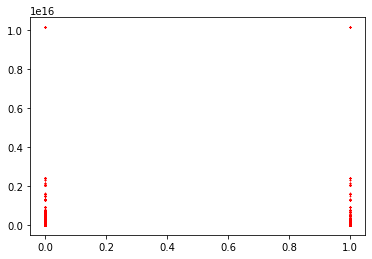

In [10]:
import matplotlib.pyplot as plt
import numpy as np
arr1 = np.array(df['score'].to_list())
arr2 = np.array(df['Facebook Id'].to_list())
print(arr1.mean())
plt.scatter(arr1,arr2,s=0.3, c='r' )
plt.style.use('ggplot')


# Training

In [1]:
import pytorch_lightning as pl
from nlp_utils.data_module import CrowdTangleDataModule, PlainCrowdTangleDataModule
from nlp_utils.model import BaseModel,BertCustomModelForShap, BiLSTMModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
%load_ext tensorboard

In [13]:
# Start tensorboard
! pkill tensorboard
! rm -r /tmp/.tensorboard-info
%tensorboard --logdir lightning_logs --bind_all

'pkill' is not recognized as an internal or external command,
operable program or batch file.
rm: cannot remove `/tmp/.tensorboard-info': No such file or directory


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 4100.

In [2]:
# config from notebooks
config = {
    'batch_size': 128,
    'dataset_path': '../../data/USParties/v2/USParties_preprocessed.csv',
    'category_group_id': False, # impacts size of data_module.class_encoder.categories_
    'learning_rate': 1e-4
}

In [3]:
# config used by Simon
config = {
    'batch_size': 32,
    'dataset_path': '../../data/USParties/v2/USParties_preprocessed.csv',
    'learning_rate': 0.001,
    "category_group_id": False,  # encodes the group id into the category one-hot-vector
    "category_type": True,  # encodes the post type into the category one-hot-vector
    "category_tld": False,  #  encodes the links top level domain (tld) into the category one-hot-vector
}

## read dataset + labels

In [16]:
data_module = CrowdTangleDataModule(config=config)
#data_module = PlainCrowdTangleDataModule(config=config)
data_module.setup()
# tokenizer for decoding sentences
tokenizer = data_module.get_tokenizer() 

In [17]:
category_vector_length = len(data_module.class_encoder.get_feature_names())
config['category_encoded_length'] = category_vector_length
config['category_encoder_out'] = category_vector_length
config['vocab_size'] = len(data_module.vocab)


In [18]:
#model = BaseModel(config)
model = BertCustomModelForShap(config)
trainer = pl.Trainer(gpus=1,
                     log_every_n_steps=1,
                     flush_logs_every_n_steps=1,
                     callbacks=[EarlyStopping(monitor='val_loss')],
                     max_epochs=20) #, max_epochs=10, overfit_batches=10)
trainer.fit(model, data_module)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | train_metric     | MeanSquaredError | 0     


Validation sanity check: 0it [00:00, ?it/s]

The ``compute`` method of metric MeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [19]:
y_lst, encoded_texts_lst, category_vectors_lst, features = next(iter(data_module.train_dataloader()))

In [19]:
# only works if category group id = True
# len(data_module.class_encoder.categories_[2])

# Evaluation

In [4]:
import pandas as pd
from nlp_utils.data_module import PlainCrowdTangleDataModule, CrowdTangleDataModule, GroupId2Name, inverse_transform
from nlp_utils.model import BaseModel, BiLSTMModel, BertCustomModel, BertCustomModelForShap
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from glob import glob
import ipywidgets as widgets
from tqdm.notebook import tqdm
import pandas as pd
import torch
import seaborn as sb
import re
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
# Start tensorboard
! pkill tensorboard
! rm -r /tmp/.tensorboard-info
%tensorboard --logdir lightning_logs --bind_all

'pkill' is not recognized as an internal or external command,
operable program or batch file.
rm: cannot remove `/tmp/.tensorboard-info': No such file or directory


Launching TensorBoard...

KeyboardInterrupt: 

Select a model

In [5]:
w = widgets.Dropdown(
    options=glob('lightning_logs/*/checkpoints/*.ckpt'),
    description='Select a checkpoint:'
)
w

Dropdown(description='Select a checkpoint:', options=('lightning_logs\\version_11\\checkpoints\\epoch=1-step=3…

In [6]:
model_version = re.findall("version_[0-9]+", w.value)[0]
model = BertCustomModelForShap.load_from_checkpoint(w.value)
# model = BiLSTMModel.load_from_checkpoint(w.value)

torch.no_grad()
model.eval()
model.config["batch_size"] = 1
data_module = CrowdTangleDataModule(config=model.config)
# data_module = PlainCrowdTangleDataModule(config=model.config) # for BiLSTM
data_module.setup()
model.config, model_version

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


({'column_goldlabel': 'goldlabel',
  'dataset_path': '../../data/USParties/v2/USParties_preprocessed.csv',
  'category_group_id': False,
  'category_type': True,
  'category_tld': False,
  'batch_size': 1,
  'category_encoded_length': 8,
  'category_encoder_out': 8,
  'learning_rate': 0.001,
  'vocab_min_freq': 10,
  'bilstm_hidden_dim': 150,
  'embedding_dim': 100,
  'vocab_size': 30522},
 'version_53')

In [4]:
model

BertCustomModelForShap(
  (train_metric): MeanSquaredError()
  (val_metric): MeanSquaredError()
  (test_metric): MeanSquaredError()
  (bce): BCELoss()
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12,

In [16]:
from captum.attr import LayerConductance,LayerActivation,InternalInfluence,LayerDeepLift,LayerFeatureAblation
layer_cond = LayerConductance(model, model.distilbert_tail)


In [13]:
import transformers
import shap
test_loader = data_module.test_dataloader()
batch = []
i = 0
for y_lst, encoded_texts_lst, category_vectors_lst, features in tqdm(iter(test_loader)):
    batch.append(encoded_texts_lst['input_ids'])
    i = i + 1
    if i > 10:
        break
print(i)

  0%|          | 0/1915 [00:00<?, ?it/s]

11


In [9]:
print(len(batch))

11


In [10]:
#Utilise GPU for training/testing, if available
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU Available: ", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("No GPU Available, Switching To CPU.")

GPU Available:  GeForce GTX 960M


In [17]:
final_attribution = None
i = 0
for inp in batch:
    attribution = layer_cond.attribute(inp,4)
    if final_attribution is not None:
        final_attribution = final_attribution + attribution
    else:
        final_attribution = attribution
    i = i+1
    print(i)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [42]:
final_attribution[1]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2161e-01,  3.9703e-02,
         0.0000e+00,  0.0000e+00, -2.5189e-04,  5.6463e-01, -3.7155e-04,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.3926e-01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.1235e-01,  0.0000e+00,  0.0000e+00,
         2.7436e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -3.3277e-01,  0.0000e+00,  7.0260e-01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  5.2289e-01,  0.0000e+00, -5.9325e-02,  0.0000e+00,
         0.0000e+00,  1.8314e-05,  2.3454e-05,  1.1975e+00,  0.0000e+00,
        -2.1521e-01, -3.3014e+00,  1.0026e-04,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  7.0698e-01,  0.0000e+00, -7.2914e-02, -2.9945e-01,
         0.0000e+00,  0.0000e+00,  1.0098e-01,  0.0000e+00,  1.6990e-01,
        -3.3696e-02,  0.0000e+00,  0.0000e+00,  0.0

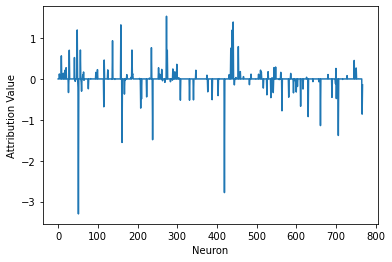

In [46]:
from matplotlib import pyplot as plt
plt.plot(final_attribution[1])
plt.xlabel("Neuron")
plt.ylabel("Attribution Value")
plt.show()